# Notes
this section is all done in the remote sever, which is a Linux server runing on 1 L40S Nvidia GPU. It includes two steps: (1) fine-tune xlm-t with english data, (2) fine-tune xlm-t with local language data.(3) analyze the results.

- Step 1: fine-tune xlm-t with english data 
    - 1.1 prepare English training data: we exactly follow the instruction in Josh's paper here, and prepared the same training set `mf_corpora_merged.csv` with an adapted version of the original code in their [GitHub Repo](https://github.com/joshnguyen99/moral_axes/tree/bce1844fd6c73c6c839aecb1e4ad9172b163e3c7/scripts/mfd)
    - 1.2 prepare Chinese training data, that's another 80% of CV dataset which is formatted in the same way as the English training data. 
    - 1.3. then we followed the same way as Josh, and replace the base model to `xlm-t`, trained 5 binary models with `xlm_base.py` and infer the results with `xlm_infer.py` with command lines
- Step 2: fine-tune xlm-t with Chinese data. used the same `xlm_base.py` for batch training and `xlm_infer.py` for inference.
- Step 3: analyze the results. `e_tool_lm.ipynb` is code to analyze the results 
    - 3.1 performance of binary models, english trained `/raw_result_xml.csv`
    - 3.2 performance of batch training with local language annotated data `raw_result_xml_batch.csv`

# Formatting and Analysis XML Raw Results
1. each moral foundation is predicted independently by the independent binary models


In [ ]:
import pandas as pd
# import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

xml = pd.read_csv('raw_result_xml.csv', index_col=0)

# add source_dataset column
dataset_map = {
    'corevalue': 'BM_CV',
    'senario': 'BM_CS' ,
    'vignette': 'BM_MFV'
}

xml['source_dataset'] = xml['source'].map(dataset_map)

In [2]:
xml['source_dataset'].value_counts()
# xml['source'].value_counts()

source_dataset
BM_CV     1544
BM_CS     1453
BM_MFV      90
Name: count, dtype: int64

In [3]:
#### Function to round the values in the classification report dictionary #####
def round_classification_report(report, digits=3):
    for key, value in report.items():
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                report[key][sub_key] = round(sub_value, digits)
        else:
            report[key] = round(value, digits)
    return report


def model_performance(df, source_label_column, predicted_label_column):
    
    """
    This function will return a dataframe, containing the classification report, model's name and coverage figure
    """

    true_labels = df[source_label_column]
    predicted_labels = df[predicted_label_column]

    # Generate classification report
    class_report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0)
    rounded_class_report = round_classification_report(class_report, digits=2)
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(rounded_class_report)
    report_df = report_df.loc[['f1-score']]
    report_df = report_df.rename(index={'f1-score': f'f1 {predicted_label_column}'})
    report_df = report_df.transpose() # transpose the dataframe
    
    # add coverage figure to a new column, so far there should be only one row in the dataframe

    return report_df

####### define a function to present the results in a table #######
def present_tables_by_BM(df, source_dataset):

    df = df[df['source_dataset'] == source_dataset]
    df_mf_all = pd.DataFrame()
    foundation = ['care', 'fairness', 'authority', 'loyalty', 'sanctity']
    
    for mf in foundation:
        df_mf = model_performance(df, f'{mf}_label', f'pred_{mf}_base')
        # rename the column
        df_mf = df_mf.rename(columns={f'f1 pred_{mf}_base': f'{mf}'})
        df_mf_all = pd.concat([df_mf_all, df_mf], axis=1)
    
    # add the ramdom baseline to the table
    # random_baseline = randome_baseline_performance(source_dataset)
    # table_display = pd.concat([table_display, random_baseline], axis=0) # row bind
    
    print(f"Machine Translation MF Measurement Results Benchmarked with {source_dataset} Dataset")
    display(df_mf_all)

In [4]:
present_tables_by_BM(xml, 'BM_MFV')

Machine Translation MF Measurement Results Benchmarked with BM_MFV Dataset


,care,fairness,authority,loyalty,sanctity
0,0.81,0.76,0.70,0.88,0.85
1,0.41,0.15,0.27,0.54,0.15
accuracy,0.71,0.62,0.58,0.81,0.74
macro avg,0.61,0.45,0.49,0.71,0.50
weighted avg,0.69,0.68,0.58,0.82,0.77


In [5]:
present_tables_by_BM(xml, 'BM_CS')

Machine Translation MF Measurement Results Benchmarked with BM_CS Dataset


,care,fairness,authority,loyalty,sanctity
0,0.76,0.79,0.66,0.91,0.89
1,0.44,0.02,0.19,0.54,0.51
accuracy,0.66,0.65,0.52,0.85,0.82
macro avg,0.60,0.40,0.42,0.73,0.70
weighted avg,0.67,0.65,0.55,0.85,0.83


In [6]:
present_tables_by_BM(xml, 'BM_CV')

Machine Translation MF Measurement Results Benchmarked with BM_CV Dataset


,care,fairness,authority,loyalty,sanctity
0,0.63,0.74,0.51,0.78,0.75
1,0.58,0.20,0.24,0.41,0.10
accuracy,0.60,0.61,0.40,0.68,0.61
macro avg,0.60,0.47,0.37,0.60,0.43
weighted avg,0.61,0.65,0.46,0.70,0.73


# Formatting and Analysis XML batch training Results

In [ ]:
import pandas as pd
# import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
# xml_batch.columns 
import matplotlib.pyplot as plt


# read the raw result of xml batch
xml_batch = pd.read_csv('raw_result_xml_batch.csv', index_col=0)

# add source_dataset column
dataset_map = {'corevalue': 'BM_CV','senario': 'BM_CS' ,'vignette': 'BM_MFV'}
xml_batch['source_dataset'] = xml_batch['source'].map(dataset_map)
xml_batch.columns



Index(['text', 'source', 'source_label', 'label', 'care_label',
       'fairness_label', 'authority_label', 'loyalty_label', 'sanctity_label',
       'pred_care_base',
       ...
       'loyalty_batch_47', 'loyalty_batch_48', 'loyalty_batch_49',
       'loyalty_batch_50', 'loyalty_batch_51', 'loyalty_batch_52',
       'loyalty_batch_53', 'loyalty_batch_54', 'loyalty_batch_55',
       'source_dataset'],
      dtype='object', length=235)

In [8]:
# define two variables for iteration
dataset = ['BM_MFV', 'BM_CS', 'BM_CV']
# foundation = ['care', 'fairness', 'authority', 'loyalty', 'sanctity']
foundation_batch = {'care': 55, 'fairness': 49, 'authority': 51, 'loyalty': 55, 'sanctity': 10} # each foundation has different number of batchs: care: 55, fairness: 50, authority: 51, loyalty: 55, sanctity: 10

xml_batch_result = {}

for ds in dataset:
    df = xml_batch[xml_batch['source_dataset'] == ds]
    
    for mf in foundation_batch.keys():
        mf_list = []
        mf_batch = foundation_batch[f'{mf}']
        for i in range(1, mf_batch+1):
            class_report = classification_report(df[f'{mf}_label'], df[f'{mf}_batch_{i}'], output_dict=True, zero_division=0)
            rounded_class_report = round_classification_report(class_report, digits=2)
            report_df = pd.DataFrame(rounded_class_report).transpose()
            # extract the value in f1-score column, 4th row, macro avg model performance 
            weighted_avg = report_df.iloc[4]['f1-score']
            value_dict = {f'weighted_avg_b_{i}': weighted_avg}
            mf_list.append(value_dict)
        xml_batch_result[f'{ds}_{mf}'] = mf_list
        print(f'{ds}_{mf} is done')
    
# Flatten the dictionary
flattened_data = {}
for key, value_list in xml_batch_result.items():
    for value_dict in value_list:
        for batch_key, f1_score in value_dict.items():
            if key not in flattened_data:
                flattened_data[key] = {}
            flattened_data[key][batch_key] = f1_score

# Create a DataFrame
xml_batch_result_flat = pd.DataFrame.from_dict(flattened_data, orient='index').transpose()

# Fill missing values with 'NA'
xml_batch_result_flat = xml_batch_result_flat.fillna('NA')

# Display the DataFrame
display(xml_batch_result_flat)

# save the result to csv
# xml_batch_result_flat.to_csv('/home/misinfo/turing_dso_misinfo/llms_mft_multilingual/paper_linked_final/experiment_lan_tool/result_raw/result_xml_batch.csv')


BM_MFV_care is done
BM_MFV_fairness is done
BM_MFV_authority is done
BM_MFV_loyalty is done
BM_MFV_sanctity is done
BM_CS_care is done
BM_CS_fairness is done
BM_CS_authority is done
BM_CS_loyalty is done
BM_CS_sanctity is done


BM_CV_care is done
BM_CV_fairness is done
BM_CV_authority is done
BM_CV_loyalty is done
BM_CV_sanctity is done


,BM_MFV_care,BM_MFV_fairness,BM_MFV_authority,BM_MFV_loyalty,BM_MFV_sanctity,BM_CS_care,BM_CS_fairness,BM_CS_authority,BM_CS_loyalty,BM_CS_sanctity,BM_CV_care,BM_CV_fairness,BM_CV_authority,BM_CV_loyalty,BM_CV_sanctity
weighted_avg_b_1,0.72,0.76,0.64,0.80,0.83,0.71,0.7,0.63,0.84,0.82,0.66,0.75,0.68,0.74,0.94
weighted_avg_b_2,0.70,0.81,0.6,0.79,0.83,0.66,0.71,0.66,0.82,0.84,0.62,0.76,0.75,0.73,0.94
weighted_avg_b_3,0.71,0.78,0.6,0.81,0.83,0.73,0.71,0.66,0.82,0.86,0.69,0.76,0.76,0.74,0.93
weighted_avg_b_4,0.71,0.84,0.6,0.81,0.83,0.69,0.72,0.66,0.83,0.87,0.67,0.76,0.77,0.74,0.93
weighted_avg_b_5,0.72,0.84,0.6,0.79,0.83,0.69,0.72,0.67,0.84,0.87,0.68,0.76,0.77,0.76,0.9
weighted_avg_b_6,0.72,0.8,0.59,0.82,0.83,0.73,0.71,0.67,0.85,0.84,0.72,0.77,0.77,0.78,0.94
weighted_avg_b_7,0.64,0.78,0.58,0.79,0.83,0.67,0.7,0.67,0.84,0.86,0.68,0.77,0.77,0.78,0.92
weighted_avg_b_8,0.75,0.73,0.59,0.80,0.83,0.73,0.69,0.67,0.84,0.86,0.74,0.78,0.77,0.77,0.94
weighted_avg_b_9,0.65,0.78,0.58,0.84,0.83,0.69,0.71,0.67,0.84,0.86,0.70,0.78,0.77,0.79,0.94
weighted_avg_b_10,0.71,0.78,0.59,0.82,0.83,0.72,0.7,0.67,0.85,0.86,0.73,0.79,0.77,0.79,0.93


In [ ]:
import matplotlib.pyplot as plt
df = pd.read_csv('result_xml_batch.csv', index_col=0, dtype=str)

# Calculate the average weighted F1 score of the five foundations


# Convert 'NA' to actual NaN values
df.replace(['NA', 'nan'], np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df["Avg"] = df.iloc[:, 1:].mean(axis=1, skipna=True)

def batch_plot(dataset):
    colors = {
        'blue': '#0072B2',
        'green': '#009E73',
        'red': '#D55E00',
        'purple': '#CC79A7',
        'orange': '#E69F00',
    }
    # df = xml_batch_result_flat
    # Plotting the line chart
    plt.figure(figsize=(10, 6))
    # Set the background color to super light blue
    # plt.gca().set_facecolor('#E6F7FF')
    
    plt.plot(df[f'BM_{dataset}_care'].dropna().reset_index(drop=True), label='care', marker='o', markersize=3, color = colors['green'])
    plt.plot(df[f'BM_{dataset}_fairness'].dropna().reset_index(drop=True), label='fairness', marker='o', markersize=3, color = colors['blue'])
    plt.plot(df[f'BM_{dataset}_authority'].dropna().reset_index(drop=True), label='authority', marker='o', markersize=3, color = colors['red'])
    plt.plot(df[f'BM_{dataset}_loyalty'].dropna().reset_index(drop=True), label='loyalty', marker='o', markersize=3, color = colors['orange'])
    plt.plot(df[f'BM_{dataset}_sanctity'].dropna().reset_index(drop=True), label='sanctity', marker='o', markersize=3, color = colors['purple'])
    plt.plot(df['Avg'].dropna().reset_index(drop=True), label='XLM-Avg', marker='x'  ,markersize=3, color = 'black', linestyle=':')

    # Adding labels and title
    plt.xlabel('Data Batches')
    plt.ylabel('Weighted Avg F1 Score')
    # plt.title(f'BM_{dataset} Model Performance on Cumulated Training Data')
    plt.legend(loc = 'lower right')
    # plt.grid(True, which='minor', linestyle='--', linewidth=0.5)
    plt.tight_layout()

     # Add a dashed line at y=0.50
    plt.axhline(y=0.50, color='gray', linestyle='--', linewidth=1)


    # Set x-ticks to be numeric values based on the longest series
    max_length = max(len(df[f'BM_{dataset}_care'].dropna()), len(df[f'BM_{dataset}_fairness'].dropna()), len(df[f'BM_{dataset}_authority'].dropna()), len(df[f'BM_{dataset}_loyalty'].dropna()), len(df[f'BM_{dataset}_sanctity'].dropna()))
    plt.xticks(range(max_length))

    # Customize y-ticks to show only the range
    y_min = min(df[f'BM_{dataset}_care'].dropna().min(), 
                df[f'BM_{dataset}_fairness'].dropna().min(), 
                df[f'BM_{dataset}_authority'].dropna().min(), 
                df[f'BM_{dataset}_loyalty'].dropna().min(), 
                df[f'BM_{dataset}_sanctity'].dropna().min())
    y_max = 1.00
    plt.yticks(np.arange(np.floor(y_min), np.ceil(y_max) + 0.05, 0.05))
    # Display the plot
    plt.savefig(f"batch_{dataset}.pdf", format='pdf')
    plt.show()


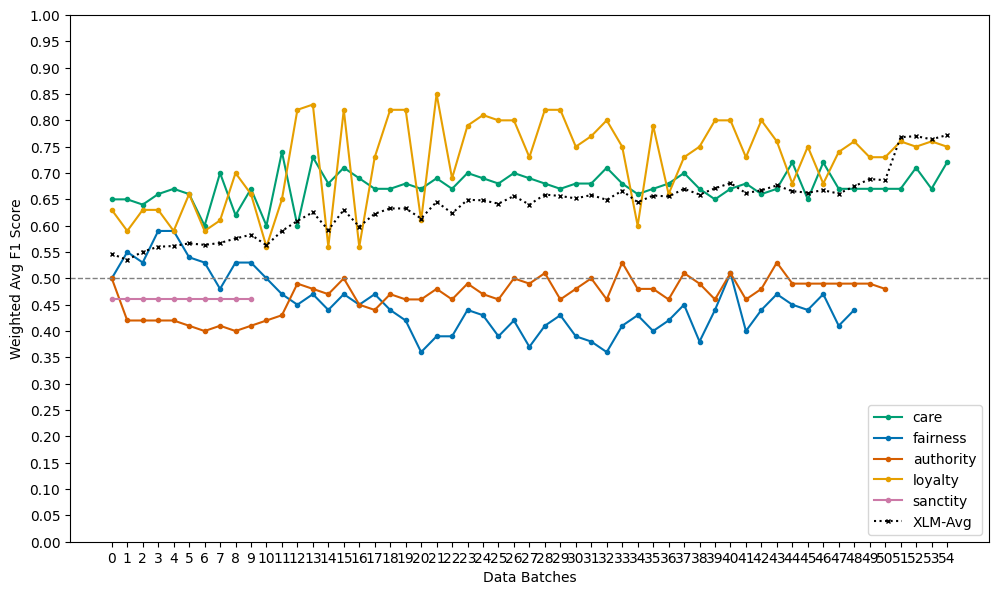

In [10]:
dataset = "MFV"
batch_plot(dataset)
# plt.savefig(f"/home/misinfo/turing_dso_misinfo/llms_mft_multilingual/paper_linked_final/experiment_lan_tool/result/batch_{dataset}.pdf", format='pdf')

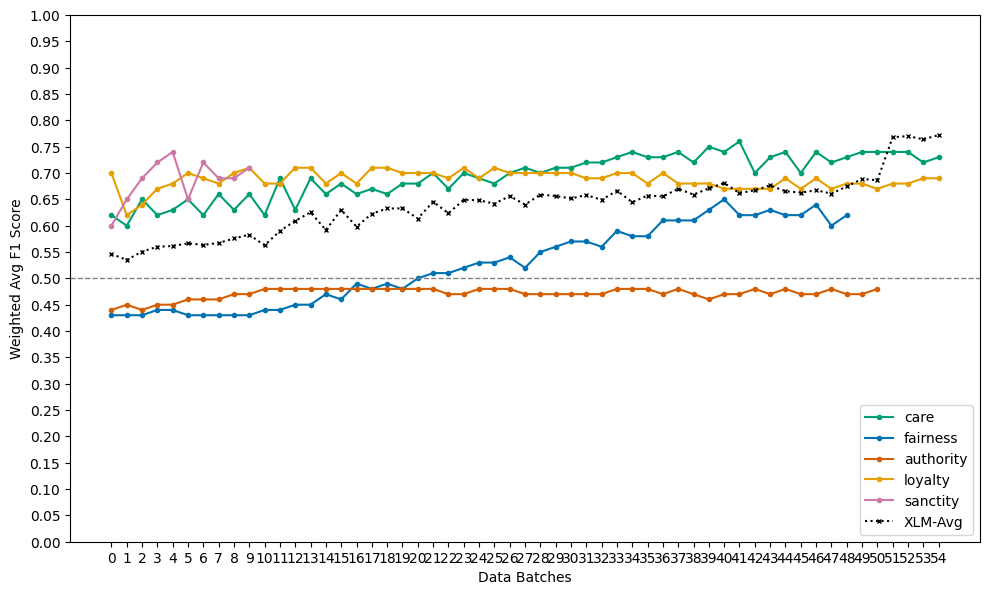

In [11]:
dataset = "CS"
batch_plot(dataset)


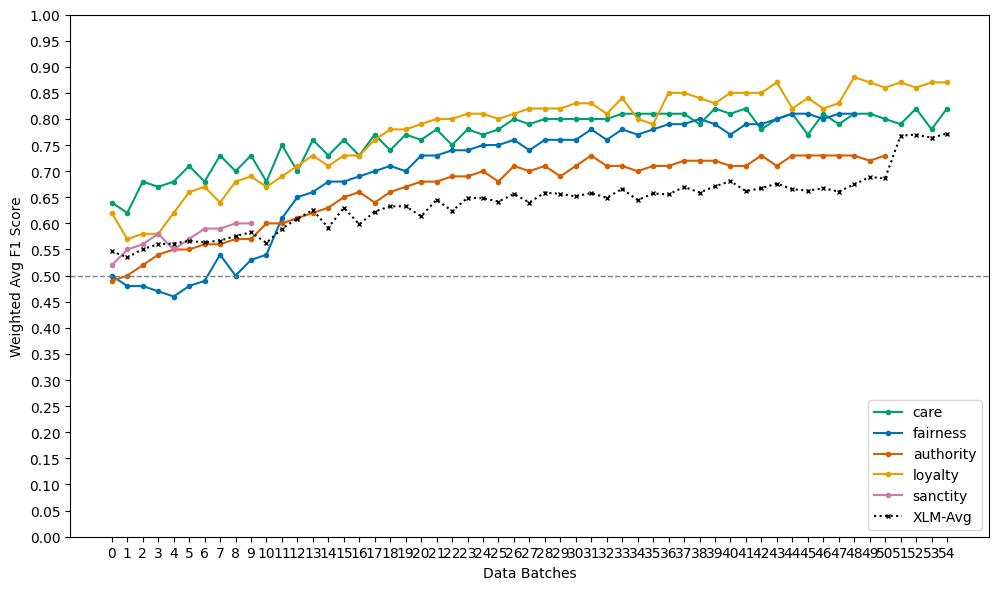

In [12]:
dataset = "CV"
batch_plot(dataset)